# Face the Data Training: Algorithms to Decode Human Emotions
First thing we need to do is to import our data.

We downloaded the dataset as a zip file from: https://www.kaggle.com/datasets/msambare/fer2013?resource=download. We then need to unzip the file and make sure that the data is accessible!
We also need to import all the necessary tools for the project!

In [107]:
import os
import zipfile
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,
    Activation, Add
)
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_datasets as tfds

# Facing the Data
Let's start investigating our data set! We need to first import our data and split it. After that, we can preprocess our data and get a look of what our dataset looks like.

In [108]:
# extracting files
with zipfile.ZipFile("fer2013.zip", "r") as zip_ref:
    zip_ref.extractall("fer2013_data")

# setting folder paths
train_dir = "fer2013_data/train"
test_dir = "fer2013_data/test"

# map emotion labels
emotion_labels = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral"
}

# load in data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=32,
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=32,
    subset='validation',
    shuffle=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


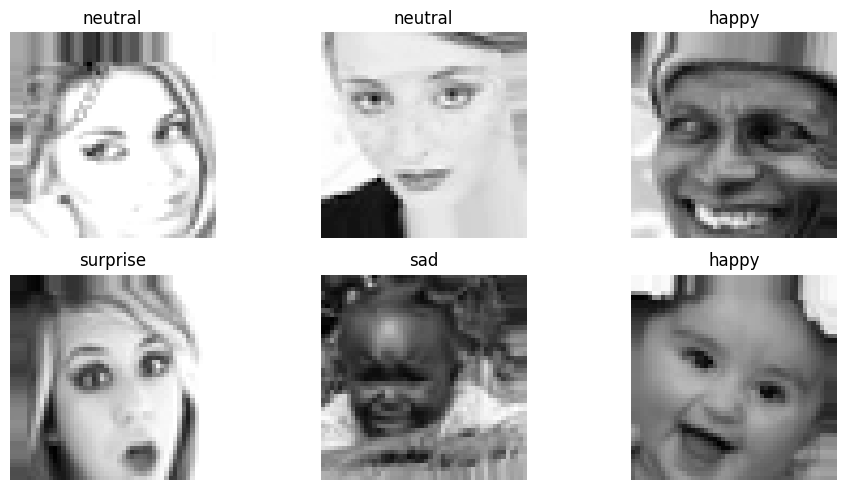

In [109]:
# print out a sample batch
x_batch, y_batch = next(train_generator)
plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_batch[i].reshape(48, 48), cmap="gray")
    label_index = np.argmax(y_batch[i])
    label_name = list(train_generator.class_indices.keys())[label_index]
    plt.title(label_name)
    plt.axis("off")
plt.tight_layout()
plt.show()

# Building a CNN Model
Now that we have a good idea of our data set, let's start building our model.

In [110]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 emotion classes
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 10, 10, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_44 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 4, 4, 128)       

Epoch 1/30
718/718 [==============================] - 21s 28ms/step - loss: 1.7982 - accuracy: 0.2513 - val_loss: 1.7261 - val_accuracy: 0.2841
Epoch 2/30
718/718 [==============================] - 20s 27ms/step - loss: 1.7023 - accuracy: 0.3121 - val_loss: 1.6336 - val_accuracy: 0.3369
Epoch 3/30
718/718 [==============================] - 21s 29ms/step - loss: 1.6003 - accuracy: 0.3727 - val_loss: 1.5205 - val_accuracy: 0.4243
Epoch 4/30
718/718 [==============================] - 20s 28ms/step - loss: 1.5131 - accuracy: 0.4118 - val_loss: 1.4427 - val_accuracy: 0.4407
Epoch 5/30
718/718 [==============================] - 20s 28ms/step - loss: 1.4494 - accuracy: 0.4365 - val_loss: 1.3859 - val_accuracy: 0.4656
Epoch 6/30
718/718 [==============================] - 20s 27ms/step - loss: 1.4075 - accuracy: 0.4611 - val_loss: 1.3544 - val_accuracy: 0.4872
Epoch 7/30
718/718 [==============================] - 20s 28ms/step - loss: 1.3763 - accuracy: 0.4714 - val_loss: 1.3392 - val_accuracy:

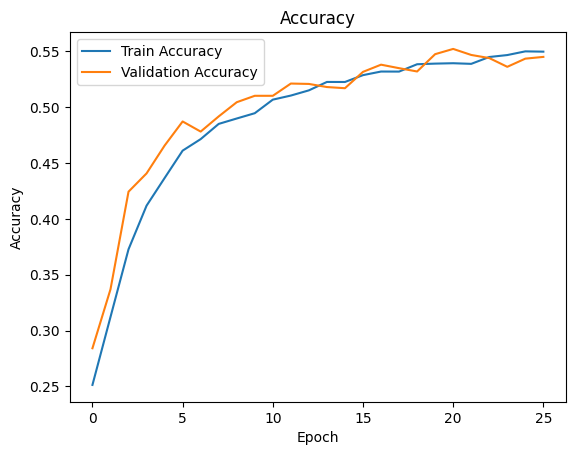

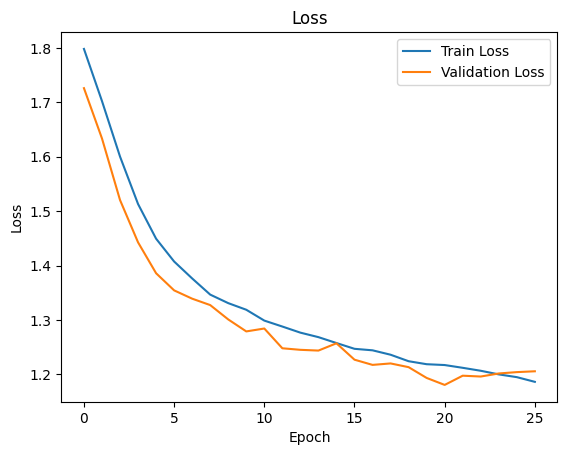

In [111]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop]
)

# Plotting
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

225/225 [==============================] - 2s 7ms/step
              precision    recall  f1-score   support

       Angry       0.54      0.43      0.48       958
     Disgust       0.90      0.08      0.15       111
        Fear       0.39      0.23      0.29      1024
       Happy       0.75      0.84      0.79      1774
         Sad       0.49      0.63      0.55      1233
    Surprise       0.42      0.47      0.45      1247
     Neutral       0.72      0.72      0.72       831

    accuracy                           0.57      7178
   macro avg       0.60      0.49      0.49      7178
weighted avg       0.57      0.57      0.56      7178



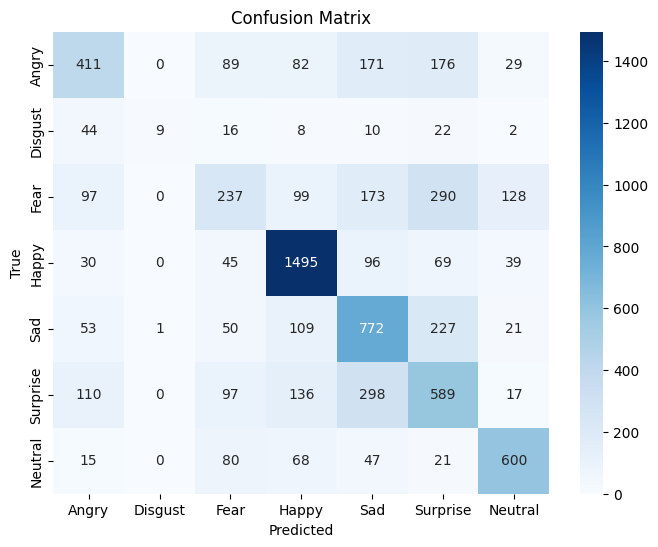

In [112]:
# Predict
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Classification report
print(classification_report(y_true, y_pred, target_names=list(emotion_labels.values())))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Correct predictions:


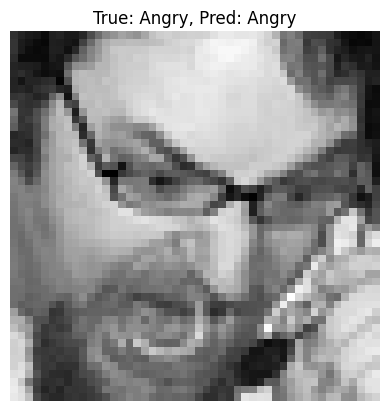

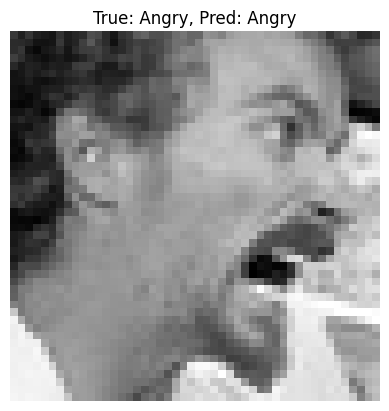

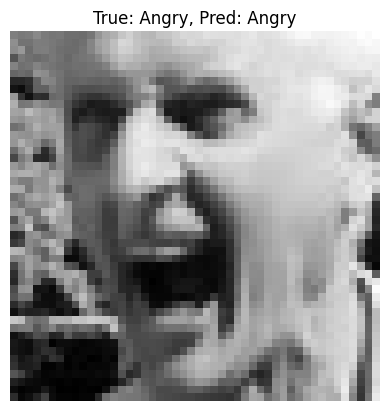

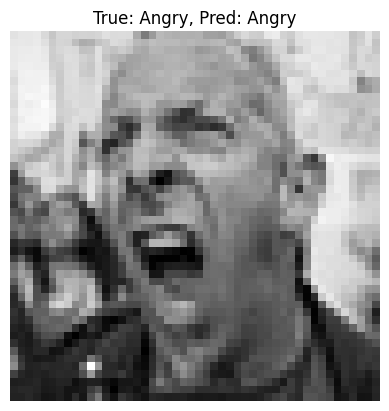

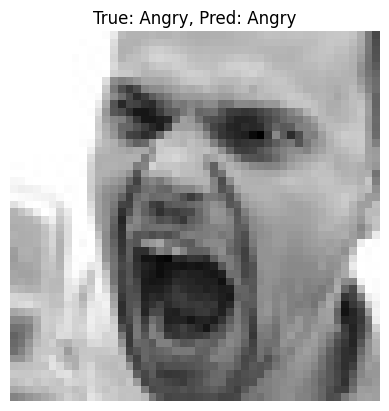

Incorrect predictions:


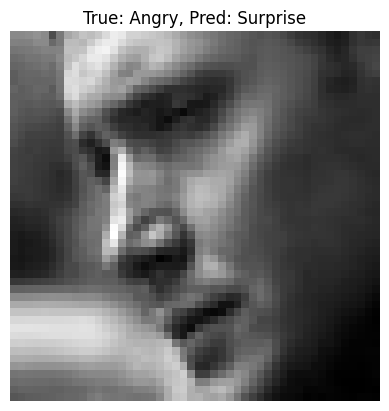

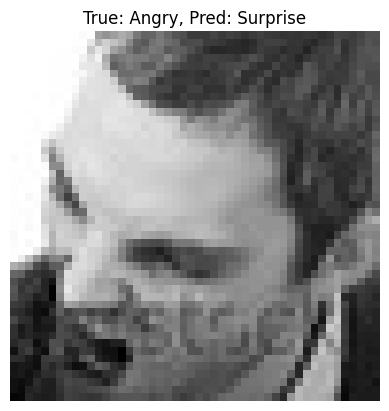

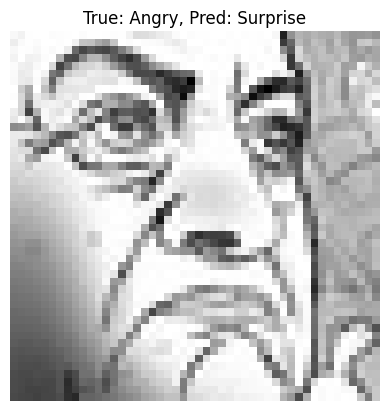

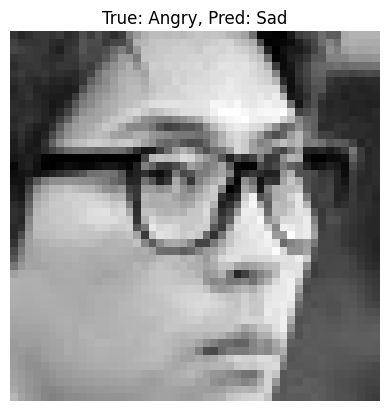

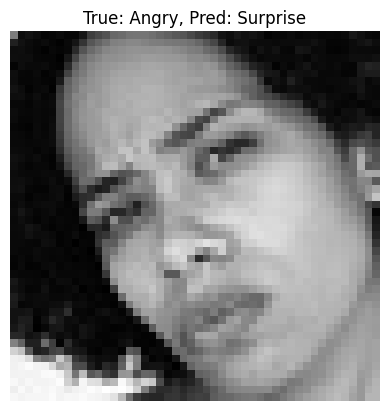

In [113]:
# Get filepaths and labels
filepaths = np.array(test_generator.filepaths)
correct = np.where(y_pred == y_true)[0]
incorrect = np.where(y_pred != y_true)[0]

# Show some correct
print("Correct predictions:")
for i in correct[:5]:
    img = plt.imread(filepaths[i])
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {emotion_labels[y_true[i]]}, Pred: {emotion_labels[y_pred[i]]}")
    plt.axis('off')
    plt.show()

# Show some incorrect
print("Incorrect predictions:")
for i in incorrect[:5]:
    img = plt.imread(filepaths[i])
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {emotion_labels[y_true[i]]}, Pred: {emotion_labels[y_pred[i]]}")
    plt.axis('off')
    plt.show()

In [114]:
def residual_block(x, filters, kernel_size=3):
    shortcut = x
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # Adjust shortcut to match dimensions (if necessary)
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, 1, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

def create_resnet_like_model(input_shape=(48, 48, 1), num_classes=7):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = residual_block(x, 64)
    x = MaxPooling2D()(x)

    x = residual_block(x, 128)
    x = MaxPooling2D()(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model_resnet = Model(inputs, outputs)
    return model

# Instantiate and compile the model
model_resnet = create_resnet_like_model()
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_resnet.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 10, 10, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_44 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 4, 4, 128)       

In [115]:
# add early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_resnet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[early_stop]
)

Epoch 1/25
718/718 [==============================] - 21s 28ms/step - loss: 1.2068 - accuracy: 0.5423 - val_loss: 1.1965 - val_accuracy: 0.5471
Epoch 2/25
718/718 [==============================] - 20s 27ms/step - loss: 1.2031 - accuracy: 0.5437 - val_loss: 1.1993 - val_accuracy: 0.5497
Epoch 3/25
718/718 [==============================] - 20s 27ms/step - loss: 1.1959 - accuracy: 0.5450 - val_loss: 1.1941 - val_accuracy: 0.5469
Epoch 4/25
718/718 [==============================] - 20s 27ms/step - loss: 1.1914 - accuracy: 0.5482 - val_loss: 1.2011 - val_accuracy: 0.5459
Epoch 5/25
718/718 [==============================] - 20s 27ms/step - loss: 1.1974 - accuracy: 0.5467 - val_loss: 1.1902 - val_accuracy: 0.5475
Epoch 6/25
718/718 [==============================] - 20s 27ms/step - loss: 1.1823 - accuracy: 0.5518 - val_loss: 1.1670 - val_accuracy: 0.5583
Epoch 7/25
718/718 [==============================] - 20s 28ms/step - loss: 1.1773 - accuracy: 0.5519 - val_loss: 1.1931 - val_accuracy:

225/225 [==============================] - 2s 7ms/step
              precision    recall  f1-score   support

       Angry       0.49      0.52      0.50       958
     Disgust       0.73      0.07      0.13       111
        Fear       0.47      0.18      0.26      1024
       Happy       0.81      0.83      0.82      1774
         Sad       0.49      0.66      0.57      1233
    Surprise       0.44      0.48      0.46      1247
     Neutral       0.68      0.76      0.72       831

    accuracy                           0.59      7178
   macro avg       0.59      0.50      0.49      7178
weighted avg       0.59      0.59      0.57      7178



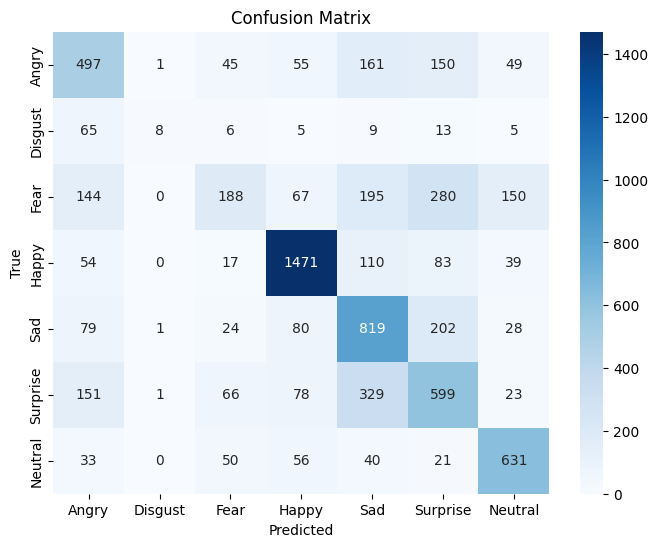

In [116]:
# Predict
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Classification report
print(classification_report(y_true, y_pred, target_names=list(emotion_labels.values())))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [117]:
# Normalization
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=64,
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [118]:
def create_vgg_like_model(input_shape=(48, 48, 1), num_classes=7):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

model_vgg = create_vgg_like_model()
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vgg.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_30 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_52 (Conv2D)          (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_31 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 24, 24, 32)        0         
 ng2D)                                                           
                                                     

In [120]:
# Training
history = model_vgg.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Evaluation
loss, acc = model_vgg.evaluate(test_generator)
print(f"Test Accuracy: {acc:.4f}")

Epoch 1/30
449/449 [==============================] - 95s 213ms/step - loss: 1.6438 - accuracy: 0.3308 - val_loss: 1.4783 - val_accuracy: 0.4242
Epoch 2/30
449/449 [==============================] - 94s 210ms/step - loss: 1.5413 - accuracy: 0.3780 - val_loss: 1.4041 - val_accuracy: 0.4522
Epoch 3/30
449/449 [==============================] - 96s 214ms/step - loss: 1.4699 - accuracy: 0.4197 - val_loss: 1.3384 - val_accuracy: 0.4866
Epoch 4/30
449/449 [==============================] - 94s 210ms/step - loss: 1.4105 - accuracy: 0.4497 - val_loss: 1.3128 - val_accuracy: 0.4976
Epoch 5/30
449/449 [==============================] - 95s 212ms/step - loss: 1.3718 - accuracy: 0.4672 - val_loss: 1.2625 - val_accuracy: 0.5272
Epoch 6/30
449/449 [==============================] - 95s 211ms/step - loss: 1.3316 - accuracy: 0.4878 - val_loss: 1.2574 - val_accuracy: 0.5348
Epoch 7/30
449/449 [==============================] - 95s 213ms/step - loss: 1.2973 - accuracy: 0.4993 - val_loss: 1.2181 - val_ac

113/113 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

       Angry       0.49      0.52      0.50       958
     Disgust       0.73      0.07      0.13       111
        Fear       0.47      0.18      0.26      1024
       Happy       0.81      0.83      0.82      1774
         Sad       0.49      0.66      0.57      1233
    Surprise       0.44      0.48      0.46      1247
     Neutral       0.68      0.76      0.72       831

    accuracy                           0.59      7178
   macro avg       0.59      0.50      0.49      7178
weighted avg       0.59      0.59      0.57      7178



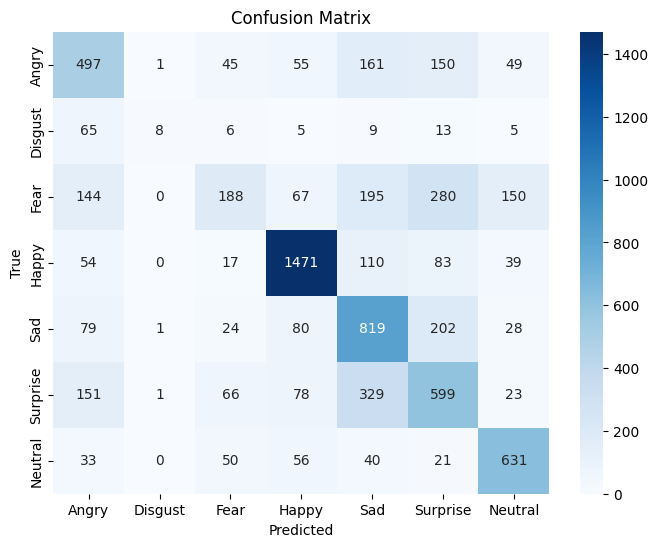

In [121]:
# Predict
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Classification report
print(classification_report(y_true, y_pred, target_names=list(emotion_labels.values())))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()